In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable
from torchvision import datasets, transforms
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
import cv2
import random

In [3]:
class Discriminator(nn.Module):
    def __init__(self, in_ch=6):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_ch, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

In [4]:
class DoubleConv2d(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv2d, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding='same'),
            nn.Dropout2d(0.2, inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding='same'),
            nn.Dropout2d(0.2, inplace=True),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.model(x)

class DownsampleConv(nn.Module):    
    def __init__(self, in_ch, out_ch):
        super(DownsampleConv, self).__init__()
        
        self.model = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv2d(in_ch, out_ch)
        )
    
    def forward(self, x):
        return self.model(x)

class UpsampleConv(nn.Module):
    def __init__(self, in_ch=1, out_ch=2):
        super(UpsampleConv, self).__init__()
        
        self.upsampler = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)
        # self.upsampler = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = DoubleConv2d(in_ch, out_ch)
    
    def forward(self, x, x_prev):
        x = self.upsampler(x)
        x = torch.cat([x, x_prev], dim=1)
        
        return self.conv(x)
        

In [5]:
class Generator(nn.Module):
    def __init__(self, in_ch = 1, out_ch = 3):
        super(Generator, self).__init__()
        
        self.input = DoubleConv2d(in_ch, 64)
        
        self.down1 = DownsampleConv(64, 128)
        self.down2 = DownsampleConv(128, 256)
        self.down3 = DownsampleConv(256, 512)
        self.down4 = DownsampleConv(512, 1024)
        
        self.up1 = UpsampleConv(1024, 512)
        self.up2 = UpsampleConv(512, 256)
        self.up3 = UpsampleConv(256, 128)
        self.up4 = UpsampleConv(128, 64)
        
        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x1 = self.input(x)
        
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        return self.tanh(self.final_conv(x))

In [6]:
def weights_init_unet(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv2d) != -1:
        m.weight.data.fill_(0.0, 0.02)
    elif isinstance(m, nn.Linear) != -1:
        m.weight.data.fill_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d) != -1:
        m.weight.data.fill_(1.0, 0.02)
        m.bias.data.fill_(0.0)

In [7]:
class MyImageLoader(torch.utils.data.Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = all_imgs

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert('RGB')
        
        image = self.transform(image)
        mask = self.random_mask(image)
        masked_image = image + mask
        
        return masked_image, mask, image

    def random_mask(self, image):
        im = image.permute(1, 2, 0)
        (h, w) = im.shape[0], im.shape[1]
        mask = Image.new('RGB', (h, w))
        
        for _ in range(random.randint(3, 15)):
            l = ImageDraw.Draw(mask)
            line_width = random.randint(0, 30)
            line_shape = [
                (random.randint(0, h - 1), random.randint(0, w - 1)),
                (random.randint(0, h - 1), random.randint(0, w - 1)),
            ]
            
            l.line(line_shape, width=line_width, fill='white')

        return transforms.ToTensor()(mask)

In [8]:
img_dir = '/kaggle/input/human-faces/Humans/'
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = MyImageLoader(img_dir, transform)

batch_size = 8
dataloader = data.DataLoader(dataset , batch_size=batch_size, shuffle=True, 
                                num_workers=2, drop_last=True)

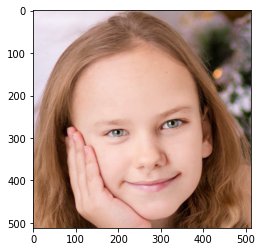

In [9]:
NUM_EPOCHS=15

(masked_image, mask, image) = next(iter(dataloader))
imshow(image[0].permute(1, 2, 0))

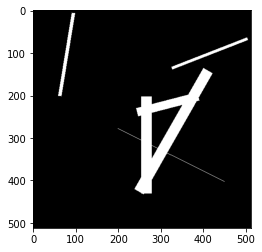

In [10]:
imshow(mask[0].permute(1, 2, 0))

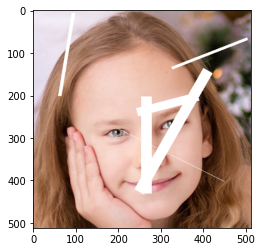

In [11]:
imshow(masked_image[0].permute(1, 2, 0))

In [12]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

print(device)

cuda


In [13]:
criterionBCE = nn.BCELoss()
criterionL1 = nn.L1Loss()

In [14]:
G = nn.DataParallel(Generator(3, 3))
G.to(device)

D = nn.DataParallel(Discriminator())
D.to(device)

DataParallel(
  (module): Discriminator(
    (model): Sequential(
      (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (12): Sigmoid()
    )
  )
)

In [15]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001, betas=[0.5, 0.999])
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0001, betas=[0.5, 0.999])

In [16]:
real_label = 1
fake_label = 0

lambda_coefficient = 100

images = []

for curr_epoch in range(NUM_EPOCHS):
    for idx, (masked_images, _, true_images) in enumerate(dataloader):
        masked_images = masked_images.cuda()
        true_images = true_images.cuda()
        masked_images, true_images = Variable(masked_images), Variable(true_images)
        
        real_target = Variable(torch.ones(masked_images.size(0), 1, 62, 62).to(device))
        fake_target = Variable(torch.zeros(masked_images.size(0), 1, 62, 62).to(device))
        
        # Train discriminator with fake images
        D_optimizer.zero_grad()
        fake_images = G(masked_images)
        
        D_input_fake = torch.cat([masked_images, fake_images], 1)
        D_fake_loss = criterionBCE(
            D(D_input_fake).detach(), fake_target
        )
        
        # Train discriminator with real images
        D_input_real = torch.cat([masked_images, true_images], 1)
        D_real_loss = criterionBCE(
            D(D_input_real), real_target
        )
        
        # Compute total D loss
        D_loss = (D_fake_loss + D_real_loss) / 2
        D_loss.backward()
        D_optimizer.step()
        
        # Compute G loss
        G_optimizer.zero_grad()
        G_loss_BCE = criterionBCE(
            D(D_input_fake), real_target
        )
        G_loss_L1 = criterionL1(fake_images, true_images)
        G_loss = G_loss_BCE + lambda_coefficient * G_loss_L1
        
        G_loss.backward()
        G_optimizer.step()
        
        if (idx % 50 == 0 and idx != 0):
            print('Epoch: %d/%d, batch: %d/%d - loss G: %.4f, loss D: %.4f'
                 % (curr_epoch + 1, NUM_EPOCHS, idx, len(dataloader), 
                  D_loss.item(), G_loss.item()))
    
    images.append((masked_images[0].detach().cpu(), true_images[0].detach().cpu(), fake_images[0].detach().cpu()))

Epoch: 1/15, batch: 50/902 - loss G: 2.1263, loss D: 18.1257
Epoch: 1/15, batch: 100/902 - loss G: 2.6542, loss D: 13.1437


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 1/15, batch: 150/902 - loss G: 2.9603, loss D: 14.5769
Epoch: 1/15, batch: 200/902 - loss G: 3.2328, loss D: 11.2114
Epoch: 1/15, batch: 250/902 - loss G: 3.3552, loss D: 14.3223
Epoch: 1/15, batch: 300/902 - loss G: 3.5304, loss D: 13.0409
Epoch: 1/15, batch: 350/902 - loss G: 3.6401, loss D: 10.8324
Epoch: 1/15, batch: 400/902 - loss G: 3.7465, loss D: 9.8383
Epoch: 1/15, batch: 450/902 - loss G: 3.8018, loss D: 12.3176
Epoch: 1/15, batch: 500/902 - loss G: 3.9508, loss D: 10.5254
Epoch: 1/15, batch: 550/902 - loss G: 4.0550, loss D: 10.4869
Epoch: 1/15, batch: 600/902 - loss G: 4.0421, loss D: 11.1463
Epoch: 1/15, batch: 650/902 - loss G: 4.2017, loss D: 8.8073
Epoch: 1/15, batch: 700/902 - loss G: 4.2352, loss D: 11.2469
Epoch: 1/15, batch: 750/902 - loss G: 4.2552, loss D: 10.3976
Epoch: 1/15, batch: 800/902 - loss G: 4.2846, loss D: 10.6198
Epoch: 1/15, batch: 850/902 - loss G: 4.3402, loss D: 9.9966
Epoch: 1/15, batch: 900/902 - loss G: 4.3599, loss D: 7.9614


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 2/15, batch: 50/902 - loss G: 4.4792, loss D: 9.9865
Epoch: 2/15, batch: 100/902 - loss G: 4.5168, loss D: 10.5202
Epoch: 2/15, batch: 150/902 - loss G: 4.6210, loss D: 9.0065
Epoch: 2/15, batch: 200/902 - loss G: 4.5801, loss D: 10.2346
Epoch: 2/15, batch: 250/902 - loss G: 4.6297, loss D: 8.0603
Epoch: 2/15, batch: 300/902 - loss G: 4.6367, loss D: 9.2178


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 2/15, batch: 350/902 - loss G: 4.6934, loss D: 8.6805
Epoch: 2/15, batch: 400/902 - loss G: 4.7852, loss D: 8.9715
Epoch: 2/15, batch: 450/902 - loss G: 4.7508, loss D: 9.7013
Epoch: 2/15, batch: 500/902 - loss G: 4.8328, loss D: 8.0089
Epoch: 2/15, batch: 550/902 - loss G: 4.7733, loss D: 8.9882
Epoch: 2/15, batch: 600/902 - loss G: 4.8018, loss D: 9.6068
Epoch: 2/15, batch: 650/902 - loss G: 4.9518, loss D: 6.5868
Epoch: 2/15, batch: 700/902 - loss G: 5.0139, loss D: 5.4589
Epoch: 2/15, batch: 750/902 - loss G: 4.9473, loss D: 6.3443
Epoch: 2/15, batch: 800/902 - loss G: 5.0364, loss D: 5.3975
Epoch: 2/15, batch: 850/902 - loss G: 5.0256, loss D: 5.5528
Epoch: 2/15, batch: 900/902 - loss G: 5.0383, loss D: 6.3390
Epoch: 3/15, batch: 50/902 - loss G: 5.0393, loss D: 5.4443
Epoch: 3/15, batch: 100/902 - loss G: 5.1133, loss D: 4.9786
Epoch: 3/15, batch: 150/902 - loss G: 5.0527, loss D: 6.9156


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 3/15, batch: 200/902 - loss G: 5.1531, loss D: 7.4692
Epoch: 3/15, batch: 250/902 - loss G: 5.1299, loss D: 6.1811
Epoch: 3/15, batch: 300/902 - loss G: 5.1523, loss D: 5.9100
Epoch: 3/15, batch: 350/902 - loss G: 5.2437, loss D: 5.5670
Epoch: 3/15, batch: 400/902 - loss G: 5.2894, loss D: 6.6993
Epoch: 3/15, batch: 450/902 - loss G: 5.3324, loss D: 5.8990
Epoch: 3/15, batch: 500/902 - loss G: 5.3154, loss D: 5.6899
Epoch: 3/15, batch: 550/902 - loss G: 5.2019, loss D: 6.9038


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 3/15, batch: 600/902 - loss G: 5.3683, loss D: 6.1000
Epoch: 3/15, batch: 650/902 - loss G: 5.4204, loss D: 6.5670
Epoch: 3/15, batch: 700/902 - loss G: 5.3602, loss D: 6.3084
Epoch: 3/15, batch: 750/902 - loss G: 5.3730, loss D: 5.5003
Epoch: 3/15, batch: 800/902 - loss G: 5.4064, loss D: 5.6322
Epoch: 3/15, batch: 850/902 - loss G: 5.4610, loss D: 5.6549
Epoch: 3/15, batch: 900/902 - loss G: 5.4182, loss D: 7.4325
Epoch: 4/15, batch: 50/902 - loss G: 5.4836, loss D: 6.7542
Epoch: 4/15, batch: 100/902 - loss G: 5.4944, loss D: 5.1636


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 4/15, batch: 150/902 - loss G: 5.4297, loss D: 6.3046
Epoch: 4/15, batch: 200/902 - loss G: 5.5711, loss D: 5.2014
Epoch: 4/15, batch: 250/902 - loss G: 5.5408, loss D: 6.4846
Epoch: 4/15, batch: 300/902 - loss G: 5.6090, loss D: 3.7672
Epoch: 4/15, batch: 350/902 - loss G: 5.6004, loss D: 5.0143
Epoch: 4/15, batch: 400/902 - loss G: 5.6105, loss D: 4.2553
Epoch: 4/15, batch: 450/902 - loss G: 5.6261, loss D: 6.6501
Epoch: 4/15, batch: 500/902 - loss G: 5.6985, loss D: 4.6334
Epoch: 4/15, batch: 550/902 - loss G: 5.6815, loss D: 5.0796


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 4/15, batch: 600/902 - loss G: 5.6384, loss D: 5.1617
Epoch: 4/15, batch: 650/902 - loss G: 5.6992, loss D: 6.0947
Epoch: 4/15, batch: 700/902 - loss G: 5.6361, loss D: 5.0822
Epoch: 4/15, batch: 750/902 - loss G: 5.7155, loss D: 4.5854
Epoch: 4/15, batch: 800/902 - loss G: 5.7461, loss D: 4.8597
Epoch: 4/15, batch: 850/902 - loss G: 5.7325, loss D: 5.4098
Epoch: 4/15, batch: 900/902 - loss G: 5.7893, loss D: 5.3951
Epoch: 5/15, batch: 50/902 - loss G: 5.8502, loss D: 4.6833
Epoch: 5/15, batch: 100/902 - loss G: 5.8286, loss D: 5.9372
Epoch: 5/15, batch: 150/902 - loss G: 5.8056, loss D: 6.3581
Epoch: 5/15, batch: 200/902 - loss G: 5.8142, loss D: 4.9869
Epoch: 5/15, batch: 250/902 - loss G: 5.8558, loss D: 6.6908


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 5/15, batch: 300/902 - loss G: 5.8800, loss D: 3.5558
Epoch: 5/15, batch: 350/902 - loss G: 5.8904, loss D: 4.2679
Epoch: 5/15, batch: 400/902 - loss G: 5.8956, loss D: 5.5553


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 5/15, batch: 450/902 - loss G: 5.9468, loss D: 4.7955
Epoch: 5/15, batch: 500/902 - loss G: 5.9394, loss D: 6.6854
Epoch: 5/15, batch: 550/902 - loss G: 5.8632, loss D: 5.2954
Epoch: 5/15, batch: 600/902 - loss G: 6.0533, loss D: 4.2996
Epoch: 5/15, batch: 650/902 - loss G: 5.9166, loss D: 4.0801
Epoch: 5/15, batch: 700/902 - loss G: 6.0208, loss D: 4.5342
Epoch: 5/15, batch: 750/902 - loss G: 6.0289, loss D: 5.5388
Epoch: 5/15, batch: 800/902 - loss G: 6.0606, loss D: 4.0284
Epoch: 5/15, batch: 850/902 - loss G: 6.0319, loss D: 5.5530
Epoch: 5/15, batch: 900/902 - loss G: 6.0610, loss D: 4.5430
Epoch: 6/15, batch: 50/902 - loss G: 6.0274, loss D: 5.3852
Epoch: 6/15, batch: 100/902 - loss G: 6.1267, loss D: 4.6759
Epoch: 6/15, batch: 150/902 - loss G: 6.1378, loss D: 4.6242
Epoch: 6/15, batch: 200/902 - loss G: 6.1729, loss D: 4.0957


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 6/15, batch: 250/902 - loss G: 6.1475, loss D: 4.6030
Epoch: 6/15, batch: 300/902 - loss G: 6.2035, loss D: 3.9240
Epoch: 6/15, batch: 350/902 - loss G: 6.1346, loss D: 5.4247
Epoch: 6/15, batch: 400/902 - loss G: 6.1771, loss D: 6.4950
Epoch: 6/15, batch: 450/902 - loss G: 6.2153, loss D: 4.5247


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 6/15, batch: 500/902 - loss G: 6.1691, loss D: 3.7428
Epoch: 6/15, batch: 550/902 - loss G: 6.1445, loss D: 4.2171
Epoch: 6/15, batch: 600/902 - loss G: 6.2783, loss D: 4.4274
Epoch: 6/15, batch: 650/902 - loss G: 6.2754, loss D: 4.5695
Epoch: 6/15, batch: 700/902 - loss G: 6.2611, loss D: 4.2038
Epoch: 6/15, batch: 750/902 - loss G: 6.3274, loss D: 4.6959
Epoch: 6/15, batch: 800/902 - loss G: 6.3223, loss D: 4.2633
Epoch: 6/15, batch: 850/902 - loss G: 6.1995, loss D: 4.6153
Epoch: 6/15, batch: 900/902 - loss G: 6.3690, loss D: 4.9582
Epoch: 7/15, batch: 50/902 - loss G: 6.3390, loss D: 4.2243


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 7/15, batch: 100/902 - loss G: 6.2865, loss D: 5.3409
Epoch: 7/15, batch: 150/902 - loss G: 6.3438, loss D: 5.1373
Epoch: 7/15, batch: 200/902 - loss G: 6.4229, loss D: 3.5081
Epoch: 7/15, batch: 250/902 - loss G: 6.4032, loss D: 4.7255
Epoch: 7/15, batch: 300/902 - loss G: 6.3751, loss D: 3.7852
Epoch: 7/15, batch: 350/902 - loss G: 6.3879, loss D: 4.6382
Epoch: 7/15, batch: 400/902 - loss G: 6.4523, loss D: 4.6070
Epoch: 7/15, batch: 450/902 - loss G: 6.4738, loss D: 4.2670
Epoch: 7/15, batch: 500/902 - loss G: 6.5013, loss D: 3.4157
Epoch: 7/15, batch: 550/902 - loss G: 6.4659, loss D: 4.0359
Epoch: 7/15, batch: 600/902 - loss G: 6.4370, loss D: 5.8025
Epoch: 7/15, batch: 650/902 - loss G: 6.4704, loss D: 5.3354
Epoch: 7/15, batch: 700/902 - loss G: 6.5423, loss D: 5.2715
Epoch: 7/15, batch: 750/902 - loss G: 6.4494, loss D: 3.8874
Epoch: 7/15, batch: 800/902 - loss G: 6.4781, loss D: 4.7401
Epoch: 7/15, batch: 850/902 - loss G: 6.5957, loss D: 4.2666
Epoch: 7/15, batch: 900/

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 8/15, batch: 150/902 - loss G: 6.5804, loss D: 4.7520
Epoch: 8/15, batch: 200/902 - loss G: 6.6325, loss D: 4.8417
Epoch: 8/15, batch: 250/902 - loss G: 6.6835, loss D: 4.0545
Epoch: 8/15, batch: 300/902 - loss G: 6.5783, loss D: 4.0528
Epoch: 8/15, batch: 350/902 - loss G: 6.6076, loss D: 4.4301
Epoch: 8/15, batch: 400/902 - loss G: 6.7288, loss D: 3.8341
Epoch: 8/15, batch: 450/902 - loss G: 6.6972, loss D: 5.1950
Epoch: 8/15, batch: 500/902 - loss G: 6.6267, loss D: 5.2000
Epoch: 8/15, batch: 550/902 - loss G: 6.7735, loss D: 4.6310
Epoch: 8/15, batch: 600/902 - loss G: 6.7140, loss D: 5.3463
Epoch: 8/15, batch: 650/902 - loss G: 6.7288, loss D: 5.2663
Epoch: 8/15, batch: 700/902 - loss G: 6.8256, loss D: 4.5113
Epoch: 8/15, batch: 750/902 - loss G: 6.7491, loss D: 4.3368
Epoch: 8/15, batch: 800/902 - loss G: 6.8562, loss D: 3.8776
Epoch: 8/15, batch: 850/902 - loss G: 6.8388, loss D: 4.4691
Epoch: 8/15, batch: 900/902 - loss G: 6.8496, loss D: 5.3727
Epoch: 9/15, batch: 50/9

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 9/15, batch: 300/902 - loss G: 6.9414, loss D: 4.8591
Epoch: 9/15, batch: 350/902 - loss G: 6.8963, loss D: 3.9642


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 9/15, batch: 400/902 - loss G: 6.8835, loss D: 3.9120
Epoch: 9/15, batch: 450/902 - loss G: 6.9725, loss D: 4.9025
Epoch: 9/15, batch: 500/902 - loss G: 6.9309, loss D: 3.8548
Epoch: 9/15, batch: 550/902 - loss G: 7.0063, loss D: 5.3214
Epoch: 9/15, batch: 600/902 - loss G: 6.8466, loss D: 5.8184
Epoch: 9/15, batch: 650/902 - loss G: 6.9797, loss D: 4.3331
Epoch: 9/15, batch: 700/902 - loss G: 6.9808, loss D: 3.1683
Epoch: 9/15, batch: 750/902 - loss G: 6.9856, loss D: 5.6766
Epoch: 9/15, batch: 800/902 - loss G: 7.0952, loss D: 4.1844
Epoch: 9/15, batch: 850/902 - loss G: 7.0818, loss D: 3.4536
Epoch: 9/15, batch: 900/902 - loss G: 7.0748, loss D: 4.2644
Epoch: 10/15, batch: 50/902 - loss G: 7.0365, loss D: 3.7514
Epoch: 10/15, batch: 100/902 - loss G: 7.1033, loss D: 4.3933
Epoch: 10/15, batch: 150/902 - loss G: 7.0637, loss D: 4.0224
Epoch: 10/15, batch: 200/902 - loss G: 7.2106, loss D: 4.3168
Epoch: 10/15, batch: 250/902 - loss G: 7.4187, loss D: 3.1225


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 10/15, batch: 300/902 - loss G: 7.2511, loss D: 3.0767
Epoch: 10/15, batch: 350/902 - loss G: 7.1762, loss D: 3.8978
Epoch: 10/15, batch: 400/902 - loss G: 7.0975, loss D: 4.3144
Epoch: 10/15, batch: 450/902 - loss G: 7.2964, loss D: 4.2189
Epoch: 10/15, batch: 500/902 - loss G: 7.5364, loss D: 3.6599


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 10/15, batch: 550/902 - loss G: 7.2440, loss D: 3.1783
Epoch: 10/15, batch: 600/902 - loss G: 7.1856, loss D: 3.1067
Epoch: 10/15, batch: 650/902 - loss G: 7.2662, loss D: 4.3135
Epoch: 10/15, batch: 700/902 - loss G: 7.2655, loss D: 4.0158
Epoch: 10/15, batch: 750/902 - loss G: 7.3592, loss D: 3.5480
Epoch: 10/15, batch: 800/902 - loss G: 7.4425, loss D: 3.9227
Epoch: 10/15, batch: 850/902 - loss G: 7.2819, loss D: 4.7579
Epoch: 10/15, batch: 900/902 - loss G: 7.6215, loss D: 3.3568
Epoch: 11/15, batch: 50/902 - loss G: 7.5348, loss D: 3.4612


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 11/15, batch: 100/902 - loss G: 7.3120, loss D: 4.9705
Epoch: 11/15, batch: 150/902 - loss G: 7.9807, loss D: 3.9732
Epoch: 11/15, batch: 200/902 - loss G: 8.2296, loss D: 2.6347


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 11/15, batch: 250/902 - loss G: 7.6524, loss D: 3.7078
Epoch: 11/15, batch: 300/902 - loss G: 7.3513, loss D: 4.9912
Epoch: 11/15, batch: 350/902 - loss G: 7.3342, loss D: 4.6330
Epoch: 11/15, batch: 400/902 - loss G: 7.7359, loss D: 4.6016
Epoch: 11/15, batch: 450/902 - loss G: 7.7069, loss D: 3.6803
Epoch: 11/15, batch: 500/902 - loss G: 7.7270, loss D: 3.7933
Epoch: 11/15, batch: 550/902 - loss G: 7.6678, loss D: 3.4944
Epoch: 11/15, batch: 600/902 - loss G: 7.5869, loss D: 4.1141
Epoch: 11/15, batch: 650/902 - loss G: 7.5577, loss D: 3.4324
Epoch: 11/15, batch: 700/902 - loss G: 7.6013, loss D: 4.4521
Epoch: 11/15, batch: 750/902 - loss G: 7.4540, loss D: 3.9408
Epoch: 11/15, batch: 800/902 - loss G: 7.6872, loss D: 3.2145
Epoch: 11/15, batch: 850/902 - loss G: 7.6847, loss D: 3.5154
Epoch: 11/15, batch: 900/902 - loss G: 8.0865, loss D: 4.0334
Epoch: 12/15, batch: 50/902 - loss G: 7.6948, loss D: 3.4560


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 12/15, batch: 100/902 - loss G: 8.1242, loss D: 3.2311
Epoch: 12/15, batch: 150/902 - loss G: 8.2517, loss D: 3.7614
Epoch: 12/15, batch: 200/902 - loss G: 9.2273, loss D: 4.1825
Epoch: 12/15, batch: 250/902 - loss G: 8.6007, loss D: 4.9257
Epoch: 12/15, batch: 300/902 - loss G: 8.8686, loss D: 3.6991
Epoch: 12/15, batch: 350/902 - loss G: 8.7116, loss D: 3.3252
Epoch: 12/15, batch: 400/902 - loss G: 7.6701, loss D: 3.6055
Epoch: 12/15, batch: 450/902 - loss G: 7.8606, loss D: 3.7853
Epoch: 12/15, batch: 500/902 - loss G: 8.0373, loss D: 2.9203
Epoch: 12/15, batch: 550/902 - loss G: 10.0751, loss D: 3.4168
Epoch: 12/15, batch: 600/902 - loss G: 8.9440, loss D: 3.7926
Epoch: 12/15, batch: 650/902 - loss G: 9.6583, loss D: 3.6555
Epoch: 12/15, batch: 700/902 - loss G: 8.0706, loss D: 3.5060
Epoch: 12/15, batch: 750/902 - loss G: 8.7263, loss D: 4.0606
Epoch: 12/15, batch: 800/902 - loss G: 8.9452, loss D: 3.2052
Epoch: 12/15, batch: 850/902 - loss G: 9.1513, loss D: 3.5459
Epoch: 

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 13/15, batch: 350/902 - loss G: 10.9146, loss D: 2.7676
Epoch: 13/15, batch: 400/902 - loss G: 13.0830, loss D: 4.8465


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 13/15, batch: 450/902 - loss G: 8.7499, loss D: 2.9615
Epoch: 13/15, batch: 500/902 - loss G: 10.1224, loss D: 3.8116
Epoch: 13/15, batch: 550/902 - loss G: 9.4267, loss D: 3.8191
Epoch: 13/15, batch: 600/902 - loss G: 10.5159, loss D: 3.4756
Epoch: 13/15, batch: 650/902 - loss G: 11.3851, loss D: 4.6021
Epoch: 13/15, batch: 700/902 - loss G: 10.7842, loss D: 3.0905
Epoch: 13/15, batch: 750/902 - loss G: 12.3256, loss D: 3.5569
Epoch: 13/15, batch: 800/902 - loss G: 8.8452, loss D: 4.3467
Epoch: 13/15, batch: 850/902 - loss G: 10.2474, loss D: 3.4506
Epoch: 13/15, batch: 900/902 - loss G: 15.7250, loss D: 3.8660
Epoch: 14/15, batch: 50/902 - loss G: 10.5304, loss D: 4.4126


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 14/15, batch: 100/902 - loss G: 14.0811, loss D: 3.9408
Epoch: 14/15, batch: 150/902 - loss G: 17.7836, loss D: 4.0606
Epoch: 14/15, batch: 200/902 - loss G: 14.9581, loss D: 3.9833
Epoch: 14/15, batch: 250/902 - loss G: 16.0400, loss D: 3.9687
Epoch: 14/15, batch: 300/902 - loss G: 15.5950, loss D: 3.5124


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 14/15, batch: 350/902 - loss G: 17.9129, loss D: 3.2577
Epoch: 14/15, batch: 400/902 - loss G: 17.5573, loss D: 4.2911
Epoch: 14/15, batch: 450/902 - loss G: 15.0507, loss D: 4.5832
Epoch: 14/15, batch: 500/902 - loss G: 16.8494, loss D: 3.4321
Epoch: 14/15, batch: 550/902 - loss G: 19.5615, loss D: 3.8190
Epoch: 14/15, batch: 600/902 - loss G: 18.4488, loss D: 3.6185
Epoch: 14/15, batch: 650/902 - loss G: 15.4192, loss D: 4.7966
Epoch: 14/15, batch: 700/902 - loss G: 15.2678, loss D: 3.5037
Epoch: 14/15, batch: 750/902 - loss G: 19.5631, loss D: 3.6249
Epoch: 14/15, batch: 800/902 - loss G: 23.9164, loss D: 3.1702
Epoch: 14/15, batch: 850/902 - loss G: 18.9529, loss D: 4.1343
Epoch: 14/15, batch: 900/902 - loss G: 24.3660, loss D: 3.4774


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 15/15, batch: 50/902 - loss G: 27.7002, loss D: 3.5824
Epoch: 15/15, batch: 100/902 - loss G: 26.5460, loss D: 3.4070
Epoch: 15/15, batch: 150/902 - loss G: 27.1424, loss D: 3.1092
Epoch: 15/15, batch: 200/902 - loss G: 22.8781, loss D: 4.0404


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 15/15, batch: 250/902 - loss G: 25.1771, loss D: 3.6625
Epoch: 15/15, batch: 300/902 - loss G: 28.2077, loss D: 4.0595
Epoch: 15/15, batch: 350/902 - loss G: 25.2646, loss D: 3.3049
Epoch: 15/15, batch: 400/902 - loss G: 28.1794, loss D: 3.2333
Epoch: 15/15, batch: 450/902 - loss G: 36.8058, loss D: 3.8948
Epoch: 15/15, batch: 500/902 - loss G: 34.1025, loss D: 3.9021
Epoch: 15/15, batch: 550/902 - loss G: 25.4823, loss D: 4.2503
Epoch: 15/15, batch: 600/902 - loss G: 36.1333, loss D: 3.0463
Epoch: 15/15, batch: 650/902 - loss G: 36.7992, loss D: 3.6894
Epoch: 15/15, batch: 700/902 - loss G: 35.1333, loss D: 4.8951
Epoch: 15/15, batch: 750/902 - loss G: 30.0764, loss D: 3.7572
Epoch: 15/15, batch: 800/902 - loss G: 28.0474, loss D: 3.8933
Epoch: 15/15, batch: 850/902 - loss G: 31.0763, loss D: 3.8315
Epoch: 15/15, batch: 900/902 - loss G: 34.7694, loss D: 3.9403


In [17]:
masked_image, true_image, gen_image = images[-1]

In [18]:
masked = masked_image.numpy().swapaxes(0, 1).swapaxes(1, 2)
true = true_image.numpy().swapaxes(0, 1).swapaxes(1, 2)
generated = gen_image.numpy().swapaxes(0, 1).swapaxes(1, 2)

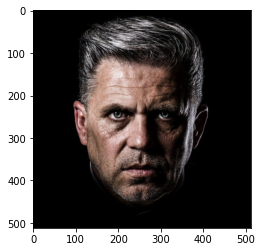

In [19]:
imshow(true)

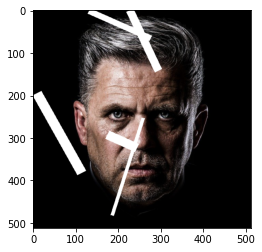

In [20]:
imshow(masked)

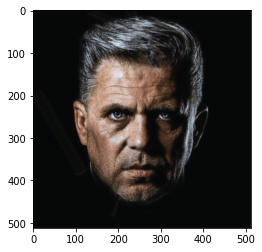

In [21]:
imshow(generated)

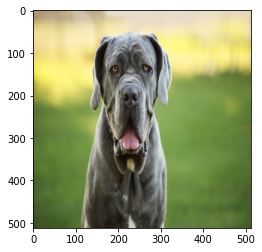

In [22]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

test_dataset = MyImageLoader('/kaggle/input/mydataset/', transform)
test_dataloader = data.DataLoader(test_dataset, batch_size=4)

test_data = next(iter(test_dataloader))
imshow(test_data[2][0].permute(1, 2, 0))

In [23]:
test_result = G(test_data[0].to(device)).detach().cpu()

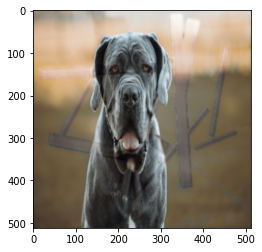

In [24]:
imshow(test_result[0].permute(1, 2, 0))

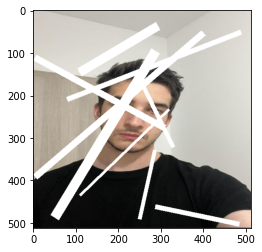

In [25]:
imshow(test_data[0][1].permute(1, 2, 0))

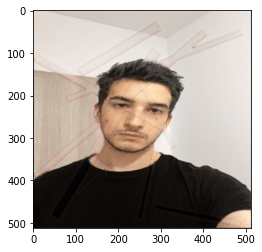

In [26]:
imshow(test_result[1].permute(1, 2, 0))